In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

### Gemini 3 and Gemini 2.5 Response Format 

In [9]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.messages import HumanMessage, SystemMessage, AIMessage

gemini3 = "gemini-3-pro-preview"
# gemini2 = "gemini-2.5-pro"
gemini2 = "gemini-2.5-flash"

system_msg = SystemMessage("You are a helpful assistant.")

query = "Explain the theory of relativity in simple terms."
messages = [system_msg, HumanMessage(query)]


In [4]:
model = ChatGoogleGenerativeAI(model=gemini3)
response = model.invoke(messages)

KeyboardInterrupt: 

In [ ]:
response

In [ ]:
response.text

In [5]:
model = ChatGoogleGenerativeAI(model=gemini2)
response = model.invoke(messages)

In [6]:
response

AIMessage(content='Of course! Let\'s break down Einstein\'s theory of relativity into its two parts, using simple analogies.\n\nThe big idea behind all of it is that **space and time are not separate and constant**. Instead, they are linked together in a single fabric called **spacetime**. What you experience as time and space depends on your motion and the gravity around you.\n\n---\n\n### Part 1: Special Relativity (The "Speed" Part)\n\nImagine you\'re driving on a highway. Special Relativity deals with what happens when you move at a **constant speed**. It\'s built on two simple but mind-bending ideas:\n\n1.  **The Laws of Physics are the Same for Everyone.** If you\'re on a perfectly smooth airplane with no windows, you can\'t tell if you\'re moving or standing still. If you throw a ball up, it comes straight back down, just like it would on the ground. Everything works the same.\n\n2.  **The Speed of Light is a Cosmic Speed Limit.** This is the weird one. The speed of light is the

In [7]:
response.content
response.content_blocks
response.usage_metadata
response.response_metadata


{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'model_name': 'gemini-2.5-pro',
 'safety_ratings': [],
 'model_provider': 'google_genai'}

### Streaming

In [16]:
model = ChatGoogleGenerativeAI(model=gemini2)

query = "Write a short story about the earth and the moon."
for chunk in model.stream(query):
    print(chunk.content, end="", flush=True)

In the cosmic nursery, amidst swirling dust and nascent stars, Terra was born. She was a vibrant swirl of greens and blues, already humming with the promise of life, a restless energy thrumming beneath her nascent crust. But she was not alone. From the same swirling chaos, a smaller, paler sibling emerged – Luna.

Terra felt an immediate, irresistible tug towards him, a gravitational embrace that settled them into a perpetual dance. Luna, in turn, felt bound to her, a constant pull that kept him orbiting, a silent sentinel in the vast, indifferent dark.

In the early eons, Terra was a tempest. Volcanoes roared, oceans boiled, and lightning cracked across her primordial skies. Luna watched it all, his pockmarked face reflecting her fiery youth, absorbing her wild, untamed light. He was her first, most loyal observer, the quiet witness to her chaotic birth.

As Terra cooled, life began to stir. Tiny, single-celled organisms bloomed into iridescent carpets, then into forests that clawed a

### Multimodal usage

In [17]:
model = ChatGoogleGenerativeAI(model=gemini3)

message = HumanMessage(
    content=[
        {"type": "text", "text": "Describe the image provided."},
        {
            "type": "image",
            "url": "https://www.shutterstock.com/image-vector/vector-cute-baby-panda-cartoon-600nw-2427356853.jpg",
        },
    ]
)
response = model.invoke([message])

In [18]:
response.content
response.text

'This is a cute, cartoon-style illustration of a giant panda. Here are the details:\n\n*   **Subject:** A baby panda sitting upright and facing forward.\n*   **Face:** The panda has a large, round head with big, expressive eyes that feature white sparkles. The eyes are surrounded by classic black patches. It has a small black nose and a smiling mouth with a pink tongue visible. The round ears are black on the outside with pink centers.\n*   **Body:** The body is chubby with black fur on the arms, legs, and back, and a round white belly. It is in a sitting position with its rear paws facing forward, revealing pink paw pads (one large pad and three smaller toe pads on each foot).\n*   **Background:** Behind the panda, there are stylized clumps of tall, green grass blades fanning out. The rest of the background is plain white.\n*   **Style:** The image uses clean lines, bright colors, and smooth shading, characteristic of vector art or digital clipart designed to look adorable ("kawaii").

In [19]:
## Reading media from local file and encoding to base64
## Now use smaller model for faster response

## image mime type example
# mime_type = "image/png"

## pdf mime type example
# mime_type = "application/pdf", type = "file"

## audio mime type example
# mime_type = "audio/mpeg", type = "audio"

import base64

image_bytes = open("data/images/panda.png", "rb").read()
bytes_base64 = base64.b64encode(image_bytes).decode("utf-8")

mime_type = "image/png"

message = HumanMessage(
    content=[
        {"type": "text", "text": "Describe the image provided."},
        {
            "type": "image",
            "base64": bytes_base64,
            "mime_type": mime_type,
        },
    ]
)

model = ChatGoogleGenerativeAI(model=gemini2)
response = model.invoke([message])

In [20]:
response

AIMessage(content='The image is a cheerful and adorable cartoon illustration featuring a baby panda sitting amidst vibrant green grass on a plain white background.\n\nThe central figure is the panda, rendered in a cute, "chibi" style with a proportionally large head and a small, round body. It has the classic black and white fur pattern: a white face and belly, with black fur forming prominent eye patches, round ears, arms, and legs.\n\nThe panda\'s face is particularly expressive. It has large, dark, sparkling eyes with small white highlights that give them a friendly, innocent look. A subtle hint of eyelashes can be seen on the outer edge of its eyes. Its nose is small, black, and oval-shaped, situated above a wide, open smile that reveals a tiny pink tongue. The ears are round, black on the outside, and have a soft pink inner lining.\n\nThe panda is in a seated position, its plump body resting on the ground. Its black paws are visible, showcasing light pink paw pads, adding to its c

In [21]:
pdf_bytes = open("data/rag-data/apple/apple 10-q q1 2024.pdf", "rb").read()
pdf_base64 = base64.b64encode(pdf_bytes).decode("utf-8")

mime_type = "application/pdf"

message = HumanMessage(
    content=[
        {"type": "text", "text": "Summarize the key financial highlights from this quarterly report."},
        {
            "type": "file",
            "base64": pdf_base64,
            "mime_type": mime_type,
        },
    ]
)
response = model.invoke([message])

In [22]:
response.text

"Apple Inc.'s quarterly report for the three months ended March 30, 2024 (Q2 2024) reveals a mixed financial picture with a slight decline in overall revenue and net income, offset by strong Services growth and significant capital returns to shareholders.\n\nHere are the key financial highlights:\n\n*   **Total Net Sales:** Decreased by 4% to **$90.75 billion** in Q2 2024, down from $94.84 billion in Q2 2023.\n*   **Net Income:** Slightly decreased by 2% to **$23.64 billion** in Q2 2024, compared to $24.16 billion in Q2 2023.\n*   **Diluted Earnings Per Share (EPS):** Remained **flat at $1.53**, primarily due to the impact of share repurchases offsetting the decline in net income.\n*   **Gross Margin Percentage:** Improved significantly to **46.6%** in Q2 2024 from 44.3% in Q2 2023, driven by a favorable Services mix.\n*   **Segment Performance:**\n    *   **Services Revenue:** Continued its strong growth trajectory, increasing by 14% to **$23.87 billion** from $20.91 billion in Q2 202

In [29]:
response.content
response.content_blocks
response.usage_metadata
response.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'model_name': 'gemini-2.5-flash',
 'safety_ratings': [],
 'model_provider': 'google_genai'}

### Tool Calling

In [ ]:
# first show ollama web_search tool
# then build weather tool

from scripts import base_tools

In [ ]:
response = base_tools.web_search.invoke({'query': 'what is the latest US stock market updates?'})
# response

In [ ]:
response = base_tools.get_weather.invoke({'location': 'Mumbai'})
# response

In [ ]:
model = ChatGoogleGenerativeAI(model=gemini2)
model_with_tools = model.bind_tools([base_tools.web_search, base_tools.get_weather])

In [ ]:
model_with_tools
response = model_with_tools.invoke("what is the weather in Mumbai today? and latest news on US stock market?")

In [ ]:
response

### Thinking support

https://ai.google.dev/gemini-api/docs/thinking

With reasoning models, you have the option to adjust the number of internal thinking tokens used (thinking_budget) or to disable thinking altogether.


In [ ]:
model = ChatGoogleGenerativeAI(model=gemini2,
                               thinking_budget=1024,
                               include_thoughts=True)

query = "explain the theory of relativity in simple terms."
response = model.invoke(query)

In [ ]:
print(response)
# print(response.text)

response.content_blocks

response

In [ ]:
model_with_tools = model.bind_tools([base_tools.web_search, base_tools.get_weather])

response = model_with_tools.invoke(query)


In [ ]:
response.content_blocks
response

### Built-in tools

Google Gemini supports a variety of built-in tools, which can be bound to the model in the usual way.

In [ ]:
model = ChatGoogleGenerativeAI(model=gemini2)

#  base_tools.get_weather -> function calling with tool use is unsupported.
model_with_tools = model.bind_tools([{"google_search": {}}, {"code_execution": {}}])

In [ ]:
query = "When is the next total solar eclipse in the US and what is 3 + 2?"
response = model_with_tools.invoke(query)

In [ ]:
print(response.text)

In [ ]:
response.response_metadata

### Context Caching

- https://ai.google.dev/gemini-api/docs/caching?hl=en&lang=python#pdfs_1
- https://ai.google.dev/gemini-api/docs/pricing

In [46]:
import time
from google import genai
from google.genai.types import CreateCachedContentConfig, Content, Part

client = genai.Client()

In [47]:
file_paths = [
    "data/rag-data/apple/apple 10-q q1 2024.pdf",
    "data/rag-data/apple/apple 10-q q2 2024.pdf"
]

uploaded_files = []
for path in file_paths:
    file = client.files.upload(file=path)
    while file.state.name == "PROCESSING":
        time.sleep(2)
        file = client.files.get(name=file.name)
    uploaded_files.append(file)

In [48]:
parts = []
for f in uploaded_files:
    part = Part.from_uri(file_uri=f.uri, mime_type=f.mime_type)
    parts.append(part)

contents = [
    Content(
        role="user",
        parts=parts,
    )
]

cache = client.caches.create(
    model=gemini2,
    config=CreateCachedContentConfig(
        display_name="Apple Q1 Q2 2024 Reports",
        system_instruction="You are a financial analyst. Use these Apple quarterly reports to answer questions.",
        contents=contents,
        ttl="1800s",
    ),
)

In [49]:
llm = ChatGoogleGenerativeAI(
    model=gemini2,
    cached_content=cache.name,
)

response = llm.invoke("Compare the revenue growth between Q1 and Q2 2024.")

In [50]:
# print(response.text)
from IPython.display import Markdown, display
display(Markdown(response.text))

To compare the revenue growth between Apple's fiscal Q1 2024 and fiscal Q2 2024, we need to extract the "Total net sales" from the provided "CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited)" tables.

**Data Extraction from Apple's Q2 2024 Form 10-Q (Fiscal Quarter Ended March 30, 2024):**

*   **Fiscal Q2 2024 (Three Months Ended March 30, 2024):**
    *   Total net sales: **$90,753 million**
*   **Fiscal Q2 2023 (Three Months Ended April 1, 2023):**
    *   Total net sales: **$94,836 million**
*   **Fiscal Q1 + Q2 2024 (Six Months Ended March 30, 2024):**
    *   Total net sales: **$210,328 million**
*   **Fiscal Q1 + Q2 2023 (Six Months Ended April 1, 2023):**
    *   Total net sales: **$211,990 million**

**Calculations:**

1.  **Fiscal Q1 2024 Revenue:**
    To find fiscal Q1 2024 revenue, we subtract fiscal Q2 2024 revenue from the cumulative six-month revenue ended March 30, 2024.
    *   Fiscal Q1 2024 Revenue = (Six Months Ended March 30, 2024) - (Three Months Ended March 30, 2024)
    *   Fiscal Q1 2024 Revenue = $210,328 million - $90,753 million = **$119,575 million**

2.  **Fiscal Q1 2023 Revenue:**
    Similarly, for fiscal Q1 2023 revenue, we subtract fiscal Q2 2023 revenue from the cumulative six-month revenue ended April 1, 2023.
    *   Fiscal Q1 2023 Revenue = (Six Months Ended April 1, 2023) - (Three Months Ended April 1, 2023)
    *   Fiscal Q1 2023 Revenue = $211,990 million - $94,836 million = **$117,154 million**

3.  **Revenue Growth for Fiscal Q1 2024:**
    *   Growth = (($119,575 million - $117,154 million) / $117,154 million) * 100
    *   Growth = ($2,421 million / $117,154 million) * 100 = **+2.07%**

4.  **Revenue Growth for Fiscal Q2 2024:**
    *   Growth = (($90,753 million - $94,836 million) / $94,836 million) * 100
    *   Growth = (-$4,083 million / $94,836 million) * 100 = **-4.31%**

**Comparison of Revenue Growth:**

*   **Fiscal Q1 2024:** Apple experienced a **+2.07%** increase in total net sales compared to fiscal Q1 2023.
*   **Fiscal Q2 2024:** Apple experienced a **-4.31%** decrease in total net sales compared to fiscal Q2 2023.

In summary, Apple's revenue grew in fiscal Q1 2024 year-over-year, but then declined in fiscal Q2 2024 year-over-year.

In [51]:
response.usage_metadata

{'input_tokens': 14482,
 'output_tokens': 3067,
 'total_tokens': 17549,
 'input_token_details': {'cache_read': 14465},
 'output_token_details': {'reasoning': 2163}}

In [52]:
response = llm.invoke("What were the total operating expenses in Q1?")

In [53]:
display(Markdown(response.text))

To determine the total operating expenses in Q1 (which refers to the three months ended December 30, 2023, as Apple's fiscal year ends in September), we need to use the data from the "Six Months Ended March 30, 2024" and "Three Months Ended March 30, 2024" columns in the Q2 2024 report.

From the **Q2 2024 Form 10-Q, page 4, "CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited)"**:

*   **Total operating expenses for the six months ended March 30, 2024:** $28,853 million (This represents Q1 + Q2)
*   **Total operating expenses for the three months ended March 30, 2024:** $14,371 million (This represents Q2)

To find the total operating expenses for Q1 (the three months ended December 30, 2023), we subtract the Q2 expenses from the six-month total:

$28,853 million (Q1 + Q2) - $14,371 million (Q2) = **$14,482 million (Q1)**

Therefore, the total operating expenses in Q1 (three months ended December 30, 2023) were **$14,482 million**.

In [54]:
response.usage_metadata

{'input_tokens': 14476,
 'output_tokens': 1526,
 'total_tokens': 16002,
 'input_token_details': {'cache_read': 14465},
 'output_token_details': {'reasoning': 1203}}

### Image Generation

In [ ]:
from langchain_google_genai import Modality
from IPython.display import Image, display

aspect_ratio = "16:9"
resolution = "2K"

analysis_model = ChatGoogleGenerativeAI(
    model=gemini2,
    cached_content=cache.name,
)

analysis_response = analysis_model.invoke(
    "Provide a detailed analysis of Apple's Q1 and Q2 2024 earnings with key financial metrics, revenue comparison, and growth trends. Format this as bullet points suitable for an infographic."
)

In [ ]:
display(Markdown(analysis_response.text))

In [55]:
image_model = ChatGoogleGenerativeAI(
    model="gemini-3-pro-image-preview",
    model_kwargs={
        "image_config": {
            "aspect_ratio": aspect_ratio,
            "image_size": resolution,
        }
    }
)

image_response = image_model.invoke(
    f"Create a professional infographic with this data:\n\n{response.text}",
    response_modalities=[Modality.TEXT, Modality.IMAGE],
)

In [56]:
image_response.content_blocks

[{'type': 'image',
  'base64': '/9j/4AAQSkZJRgABAQEBLAEsAAD/6xdkSlAAAQAAAAEAABdaanVtYgAAAB5qdW1kYzJwYQARABCAAACqADibcQNjMnBhAAAAFzRqdW1iAAAAR2p1bWRjMm1hABEAEIAAAKoAOJtxA3VybjpjMnBhOmVmZmNiYzg5LTFkNzItNjg5ZS1hODY1LTQ3OTk4MjFiMTQxZAAAABOBanVtYgAAAChqdW1kYzJjcwARABCAAACqADibcQNjMnBhLnNpZ25hdHVyZQAAABNRY2JvctKEWQauogEmGCGCWQPCMIIDvjCCA0SgAwIBAgITf8DFXrYCzoMPnf3QSrAMRZ64JjAKBggqhkjOPQQDAzBRMQswCQYDVQQGEwJVUzETMBEGA1UECgwKR29vZ2xlIExMQzEtMCsGA1UEAwwkR29vZ2xlIEMyUEEgTWVkaWEgU2VydmljZXMgMVAgSUNBIEczMB4XDTI1MTAzMDIyMzQ0N1oXDTI2MTAyNTIyMzQ0NlowazELMAkGA1UEBhMCVVMxEzARBgNVBAoTCkdvb2dsZSBMTEMxHDAaBgNVBAsTE0dvb2dsZSBTeXN0ZW0gNjAwMzIxKTAnBgNVBAMTIEdvb2dsZSBNZWRpYSBQcm9jZXNzaW5nIFNlcnZpY2VzMFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAEawavchc+90s/hPWHxK3FFJ3MlrNDMsBT9MKpPwTIQKlgKDEGTNCDKZ7pSr9psMwxnQyVriyKysDz6Pfmk73qFaOCAd8wggHbMA4GA1UdDwEB/wQEAwIGwDAfBgNVHSUEGDAWBggrBgEFBQcDBAYKKwYBBAGD6F4CATAMBgNVHRMBAf8EAjAAMB0GA1UdDgQWBBQd6OZCLAQToStyGD7pXnGFgwJTdTAfBgNVHSMEGDAWgBTae+G9tCyKheAQ1muax0rx+t/2NzBsBggrBgEFBQcB

AIMessage(content=[{'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-3-pro-image-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--a2537328-fbb0-4e61-b5d4-e4e937fe017c-0', usage_metadata={'input_tokens': 333, 'output_tokens': 2407, 'total_tokens': 2740, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 755}})
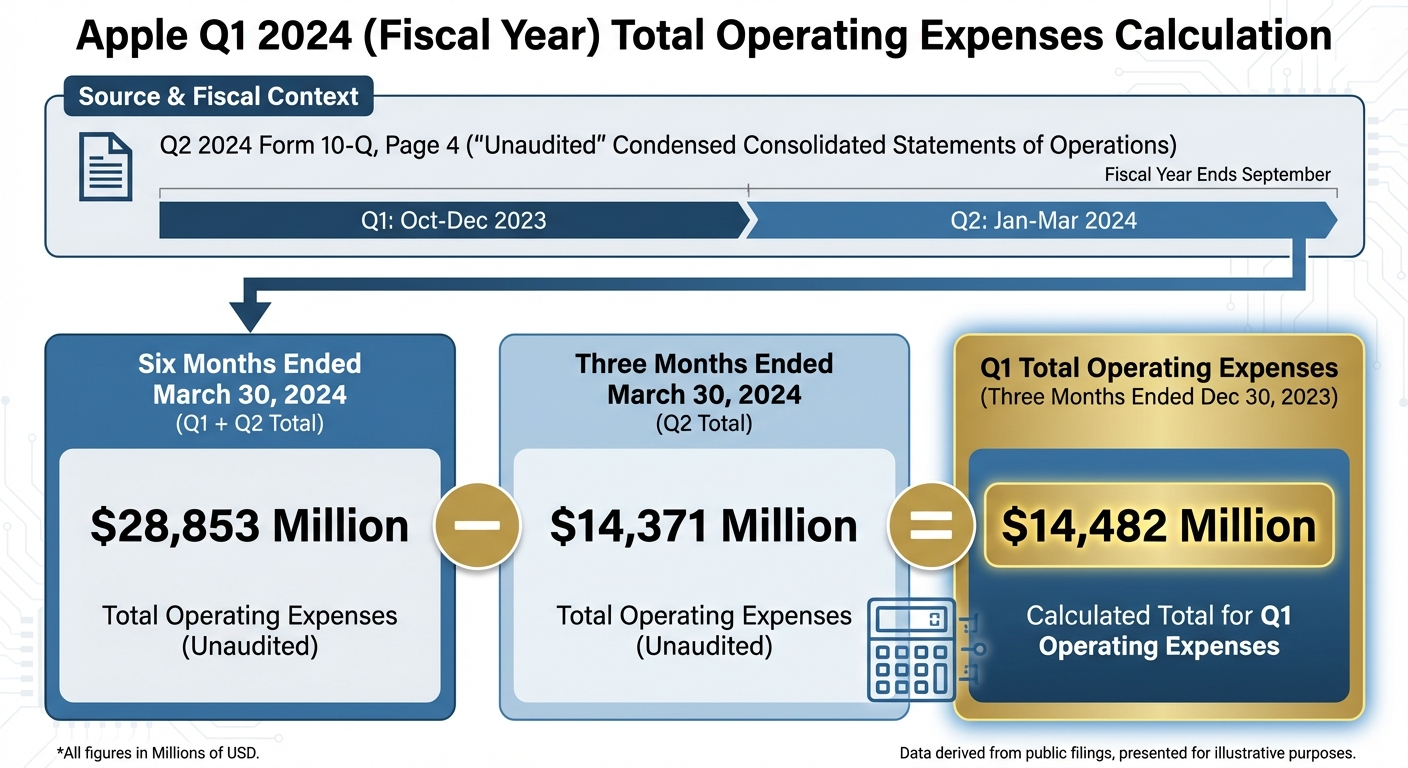

In [59]:
image_response

In [ ]:
def get_image_base64(response):
    # Go through each block in the response
    for block in response.content:
        # Check if this block is a dictionary
        if isinstance(block, dict):
            # Check if it has image data
            if "image_url" in block:
                # Extract the URL
                image_url_data = block["image_url"]
                full_url = image_url_data["url"]
                # The URL looks like: "data:image/png;base64,ACTUALBASE64DATA"
                # We only want the part after the comma
                base64_string = full_url.split(",")[1]
                return base64_string


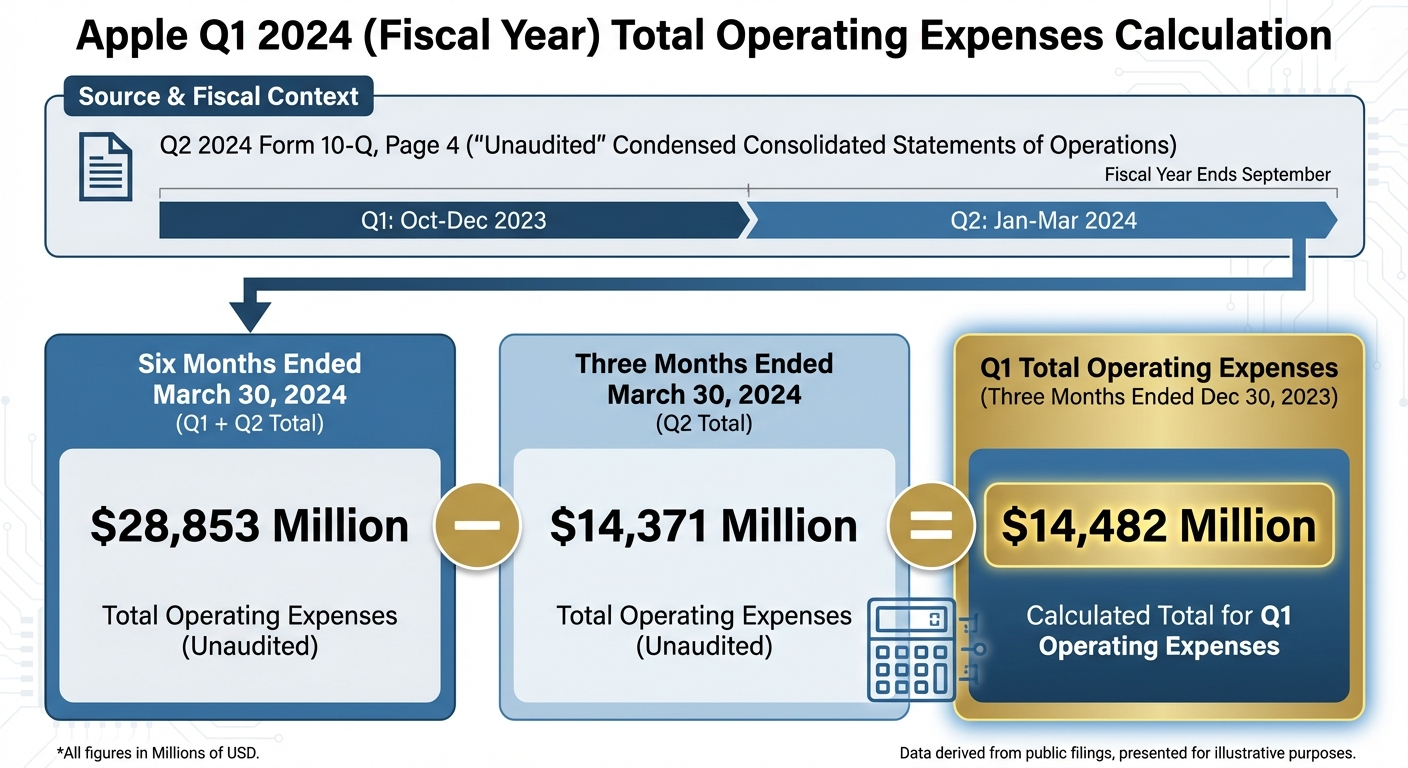

In [ ]:
image_base64 = get_image_base64(image_response)
display(Image(data=base64.b64decode(image_base64), width=800))

In [58]:
with open("data/images/apple_earnings_infographic.png", "wb") as f:
    f.write(base64.b64decode(image_base64))

### Structured Output

In [ ]:
# Use weather tool for the sample structred output
# fields -> location:str, date:str, temperature:str, condition:str

from pydantic import BaseModel

class WeatherOutput(BaseModel):
    location: str
    date: str
    temperature: str
    condition: str

model = ChatGoogleGenerativeAI(model=gemini2)
model_with_tools = model.bind_tools([base_tools.get_weather])

structured_model = model_with_tools.with_structured_output(WeatherOutput)

In [ ]:

response = structured_model.invoke("what is the weather in Mumbai today?")

In [ ]:
response